# Setup

In [1]:
# !pip install zfit==0.8.3

In [2]:
# ! pip install hepstats

In [3]:
# pip index versions zfit

In [4]:
! python --version

Python 3.8.13


In [5]:
import matplotlib.pyplot as plt
import zfit
from zfit import z  # math backend of zfit
import numpy as np
import pandas as pd

/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [6]:
import tensorflow as tf

In [7]:
zfit.__version__

'0.8.3'

In [8]:
size_normal = 10000

In [9]:
def plot_model(model, data, scale=1, plot_data=True):  # we will use scale later on

    nbins = 50

    lower, upper = data.data_range.limit1d
    x = tf.linspace(lower, upper, num=1000)  # np.linspace also works
    y = model.pdf(x) * size_normal / nbins * data.data_range.area()
    y *= scale
    plt.plot(x, y)
    data_plot = zfit.run(z.unstack_x(data))  # we could also use the `to_pandas` method
    if plot_data:
        plt.hist(data_plot, bins=nbins)

In [10]:
print(zfit.pdf.__all__)

['BasePDF', 'BaseFunctor', 'Exponential', 'CrystalBall', 'DoubleCB', 'Gauss', 'Uniform', 'TruncatedGauss', 'WrapDistribution', 'Cauchy', 'Poisson', 'Chebyshev', 'Legendre', 'Chebyshev2', 'Hermite', 'Laguerre', 'RecursivePolynomial', 'ProductPDF', 'SumPDF', 'GaussianKDE1DimV1', 'KDE1DimGrid', 'KDE1DimExact', 'KDE1DimFFT', 'KDE1DimISJ', 'FFTConvPDFV1', 'ConditionalPDFV1', 'ZPDF', 'SimplePDF', 'SimpleFunctorPDF']


# Creating different models and will try to fit them to data from a Gaussian

Creating the observable

In [11]:
mass_obs = zfit.Space('mass', (0, 1000))

In [12]:
# Gaussian 1

mu = zfit.Parameter('mu', 100, -300, 300, step_size=0.2)
sigma_num = zfit.Parameter('sigma42', 500, 0, 1000, floating=False)
gauss1 = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma_num)

In [13]:
# Gaussian 2

mu = zfit.Parameter('mu-2', 200, -500, 500, step_size=0.2)
sigma_num = zfit.Parameter('sigma42-2', 300, 0, 900, floating=False)
gauss2 = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma_num)

In [14]:
# Signal component (CrystalBall)

mu_sig = zfit.Parameter('mu_sig', 400, 100, 600)
sigma_sig = zfit.Parameter('sigma_sig', 50, 1, 100)
alpha_sig = zfit.Parameter('alpha_sig', 200, 100, 400, floating=False)  # won't be used in the fit
n_sig = zfit.Parameter('n sig', 4, 0.1, 30, floating=False)
signal = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_sig, sigma=sigma_sig, alpha=alpha_sig, n=n_sig)

In [15]:
# combinatorial background (Exponential)

lam = zfit.Parameter('lambda', -0.01, -0.05, -0.001)
comb_bkg = zfit.pdf.Exponential(lam, obs=mass_obs)

In [16]:
#KDE

part_reco_data = np.random.normal(loc=200, scale=150, size=700)
part_reco_data = zfit.Data.from_numpy(obs=mass_obs, array=part_reco_data)  # we don't need to do this but now we're sure it's inside the limits

part_reco = zfit.pdf.KDE1DimExact(obs=mass_obs, data=part_reco_data, bandwidth='adaptive_zfit')

In [17]:
sampler = gauss1.create_sampler(10000)

In [18]:
sampler.resample()

In [19]:
numpy_data = sampler.numpy()

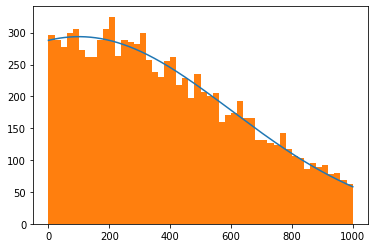

In [20]:
plot_model(gauss1, sampler)

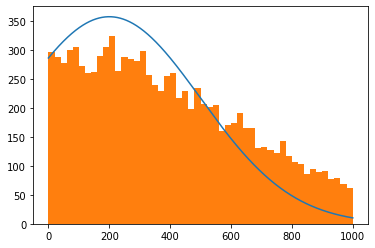

In [21]:
plot_model(gauss2, sampler)

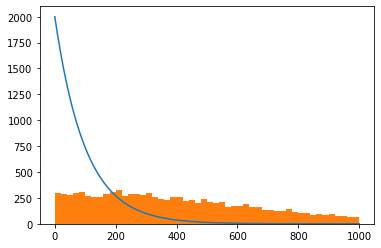

In [22]:
plot_model(comb_bkg, sampler)

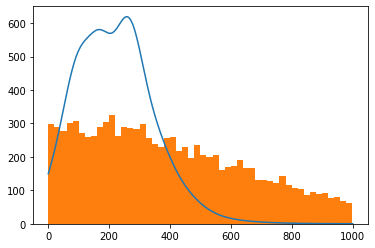

In [23]:
plot_model(part_reco, sampler)

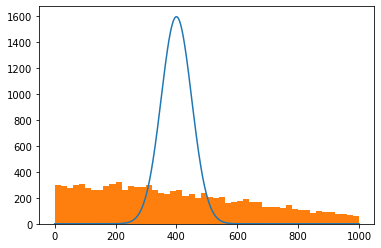

In [24]:
plot_model(signal, sampler)

# Loss for each model and analyzing useful parameters

In [25]:
nll_gauss1 = zfit.loss.UnbinnedNLL(gauss1, sampler)
nll_gauss1.get_params()

OrderedSet([<zfit.Parameter 'mu' floating=True value=100>])

In [26]:
nll_gauss2 = zfit.loss.UnbinnedNLL(gauss2, sampler)
nll_gauss2.get_params()

OrderedSet([<zfit.Parameter 'mu-2' floating=True value=200>])

In [27]:
nll_comb_bkg = zfit.loss.UnbinnedNLL(comb_bkg, sampler)
nll_comb_bkg.get_params()

OrderedSet([<zfit.Parameter 'lambda' floating=True value=-0.01>])

In [28]:
nll_part_reco = zfit.loss.UnbinnedNLL(part_reco, sampler)
nll_part_reco.get_params()

OrderedSet()

In [29]:
nll_signal = zfit.loss.UnbinnedNLL(signal, sampler)
nll_signal.get_params()

OrderedSet([<zfit.Parameter 'mu_sig' floating=True value=400>, <zfit.Parameter 'sigma_sig' floating=True value=50>])

# Minimization and looking at values of parameters

In [30]:
minimizer = zfit.minimize.Minuit()

## Gaussian 1

In [31]:
result_gauss1 = minimizer.minimize(nll_gauss1)

In [32]:
result_gauss1.hesse()

{<zfit.Parameter 'mu' floating=True value=110.6>: {'error': 9.69603856424695,
  'cl': 0.68268949}}

In [33]:
result_gauss1.valid

True

In [34]:
result_gauss1.converged

True

In [35]:
# edm – The estimated distance to minimum which is the criterion value at the minimum.

result_gauss1.edm

0.00019456423119755848

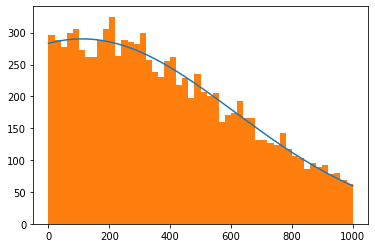

In [36]:
plot_model(gauss1, sampler)

## Gaussian 2

In [37]:
result_gauss2 = minimizer.minimize(nll_gauss2)

In [38]:
result_gauss2.hesse()

{<zfit.Parameter 'mu-2' floating=True value=321.2>: {'error': 3.937968341868723,
  'cl': 0.68268949}}

In [39]:
result_gauss2.valid

True

In [40]:
result_gauss2.converged

True

In [41]:
result_gauss2.edm

9.454470385342847e-05

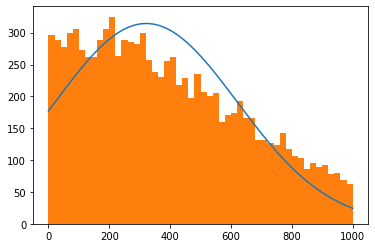

In [42]:
plot_model(gauss2, sampler)

## Combinatorial background exponential

In [43]:
result_comb_bkg = minimizer.minimize(nll_comb_bkg)

In [44]:
result_comb_bkg.hesse()

{<zfit.Parameter 'lambda' floating=True value=-0.001359>: {'error': 3.623429067227573e-05,
  'cl': 0.68268949}}

In [45]:
result_comb_bkg.valid

True

In [46]:
result_comb_bkg.converged

True

In [47]:
result_comb_bkg.edm

1.0540820959673423e-07

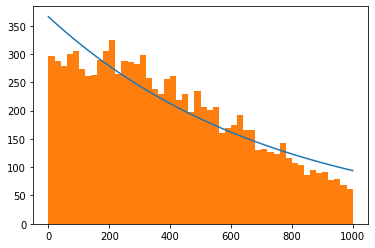

In [48]:
plot_model(comb_bkg, sampler)

## KDE1 (has no parameters, nothing to minimize)

In [49]:
# result_part_reco = minimizer.minimize(nll_part_reco)

## CrystalBall Signal

In [50]:
result_signal = minimizer.minimize(nll_signal)

In [51]:
result_signal.hesse()

{<zfit.Parameter 'mu_sig' floating=True value=390>: {'error': 1.000385507969569,
  'cl': 0.68268949},
 <zfit.Parameter 'sigma_sig' floating=True value=100>: {'error': 6.129853910147046e-06,
  'cl': 0.68268949}}

In [52]:
result_signal.valid

False

In [53]:
result_signal.edm

1.718446802685499e-05

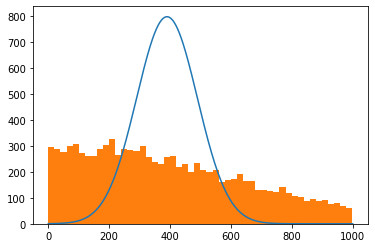

In [54]:
plot_model(signal, sampler)

In [55]:
result_signal.message

'parameter(s) at their limit.'

In [56]:
result_signal.converged

True

# hepstats.hypotests.core.discovery module

In [57]:
from zfit.loss import ExtendedUnbinnedNLL

from zfit.minimize import Minuit

In [58]:
bounds = (0.1, 3.0)

obs = zfit.Space('x', limits=bounds)

In [59]:
# Creating zfit data from Numpy that matches the bounds

bkg = np.random.exponential(0.5, 300)
peak = np.random.normal(1.2, 0.1, 25)
data = np.concatenate((bkg, peak))
data = data[(data > bounds[0]) & (data < bounds[1])]
N = data.size
data = zfit.data.Data.from_numpy(obs=obs, array=data)

In [60]:
# Creating the parameters, two models (Gaussian and Exponential), 
# and a loss from a combined model of signal + background

lambda_ = zfit.Parameter("lambda-2", -2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Ns-2", 20., -20., N)
Nbkg = zfit.Parameter("Nbkg-2", N, 0., N*1.1)

In [62]:
# Deprecated way of summing pdf and then adding a frac
signal =zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1)
signal_extended = signal.create_extended(Nsig)

background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
background_extended = background.create_extended(Nbkg)

composed_pdf_extended = zfit.pdf.SumPDF([signal_extended, background_extended])

loss_sum_extended = zfit.loss.ExtendedUnbinnedNLL(composed_pdf_extended, data=data)

Importando las librerías correspondientes a Hepstats

In [63]:
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import Discovery
from hepstats.hypotests.parameters import POI

/home/carlos/anaconda3/envs/zfit_latest/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
calculator = AsymptoticCalculator(loss_sum_extended, Minuit())
poinull = POI(Nsig, 0)
discovery_test = Discovery(calculator, poinull)
discovery_test.result()

Get fit best values!

p_value for the Null hypothesis = 1.3668512199860317e-07
Significance (in units of sigma) = 5.140938009436714


(1.3668512199860317e-07, 5.140938009436714)

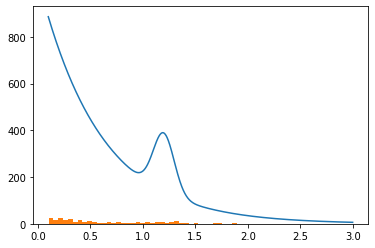

In [65]:
plot_model(composed_pdf_extended, data)

In [66]:
result_sum_extended = minimizer.minimize(loss_sum_extended)

In [67]:
result_sum_extended

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_10, Composed_autoparam_11]] data=[<zfit.core.data.Data object at 0x7f9a54068fa0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 4.5e-05 │ 1005        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name        value    at limit
--------  -------  ----------
Ns-2        32.69       False
Nbkg-2      234.4       False
lambda-2   -2.005       False

In [68]:
result_sum_extended.hesse()

{<zfit.Parameter 'Ns-2' floating=True value=32.69>: {'error': 7.879153799847751,
  'cl': 0.68268949},
 <zfit.Parameter 'Nbkg-2' floating=True value=234.4>: {'error': 16.249511991305948,
  'cl': 0.68268949},
 <zfit.Parameter 'lambda-2' floating=True value=-2.005>: {'error': 0.15205368678161435,
  'cl': 0.68268949}}

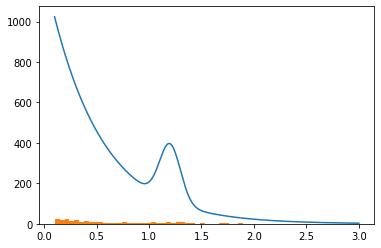

In [69]:
plot_model(composed_pdf_extended, data)